## Transformada de Hough

In [1]:
#%matplotlib

import numpy as np 
import cv2 as cv
import matplotlib.pyplot as plt

#### Transformada de Hough - Líneas

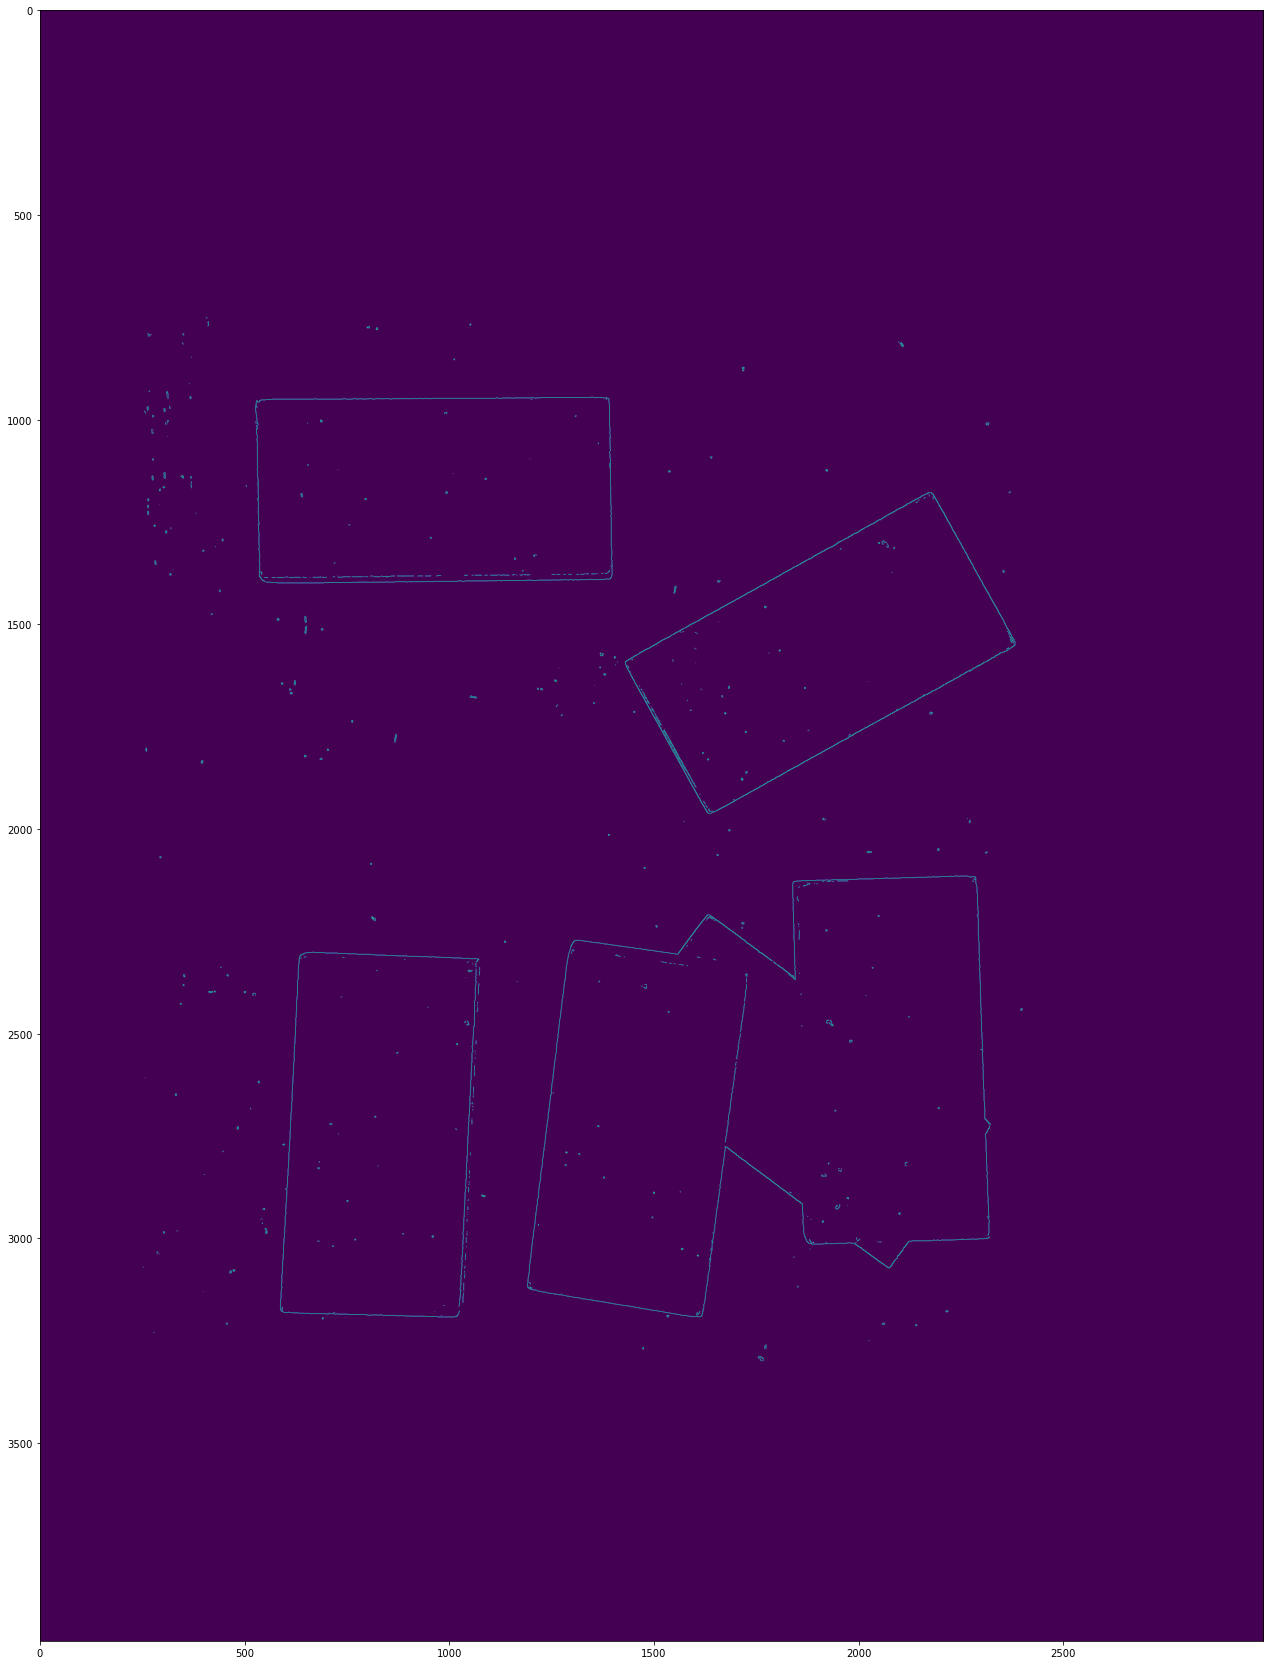

In [2]:
### Leemos la imagen
#=================
img = cv.imread('bloques1.jpg')
gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)

# Creamos una máscara para procesar solo la parte de la imagen que nos interesa
#==============================================================================

x, y = np.mgrid[:gray.shape[0], :gray.shape[1]]
mask = (y > 250) & (y < 2500) & (x > 750) & (x < 3300)

# Obtenemos los bordes por Canny
#===============================
edges = cv.Canny(gray,150,160,apertureSize = 3)
edges *= mask
#plt.figure(figsize=(20,20))
plt.rcParams["figure.figsize"] = (40,30)
plt.imshow(edges)
plt.show()

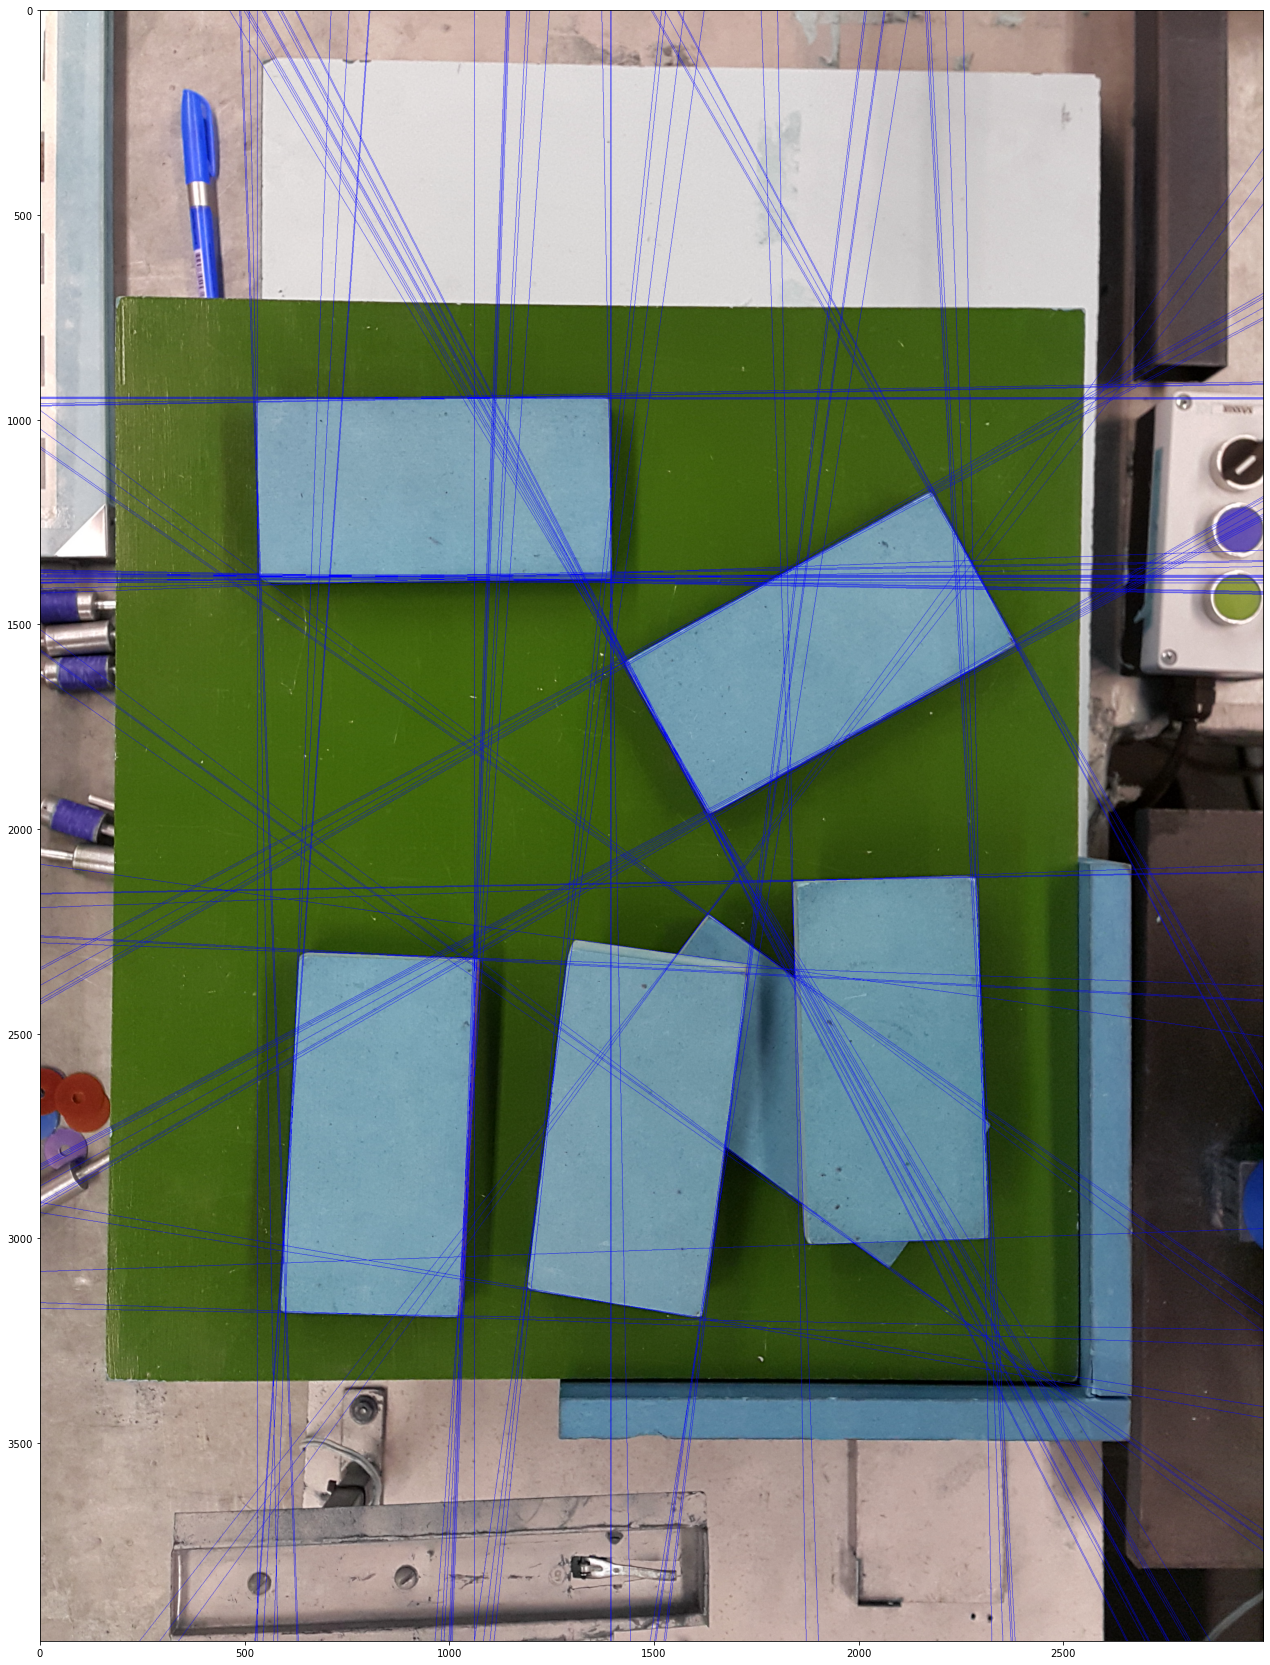

In [3]:
# Obtenemos las líneas por la transformada de Hough
#==================================================
rho_step = 1
theta_step = (np.pi/180)*1
thresh = 80
lines = cv.HoughLines(edges,rho_step,theta_step,thresh)

img1= img.copy()
img2= img.copy()

# Dibujamos lo resultados
#========================
for line in lines:
    rho,theta = line[0]
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho
    x1 = int(x0 + 10000*(-b))
    y1 = int(y0 + 10000*(a))
    x2 = int(x0 - 10000*(-b))
    y2 = int(y0 - 10000*(a))
    cv.line(img1,(x1,y1),(x2,y2),(0,0,255),1)


plt.imshow(img1)
plt.show()

Vemos que para los parametros elegidos, estamos encontando muchas lineas que nos nos sirven, por lo que vamos a utilizar un threshgold un poco mas alto. Además, como las linas que estamos buscando estan muy definidas, podemos disminuir los pasos de theta y de rho para obtener mejores resultados.

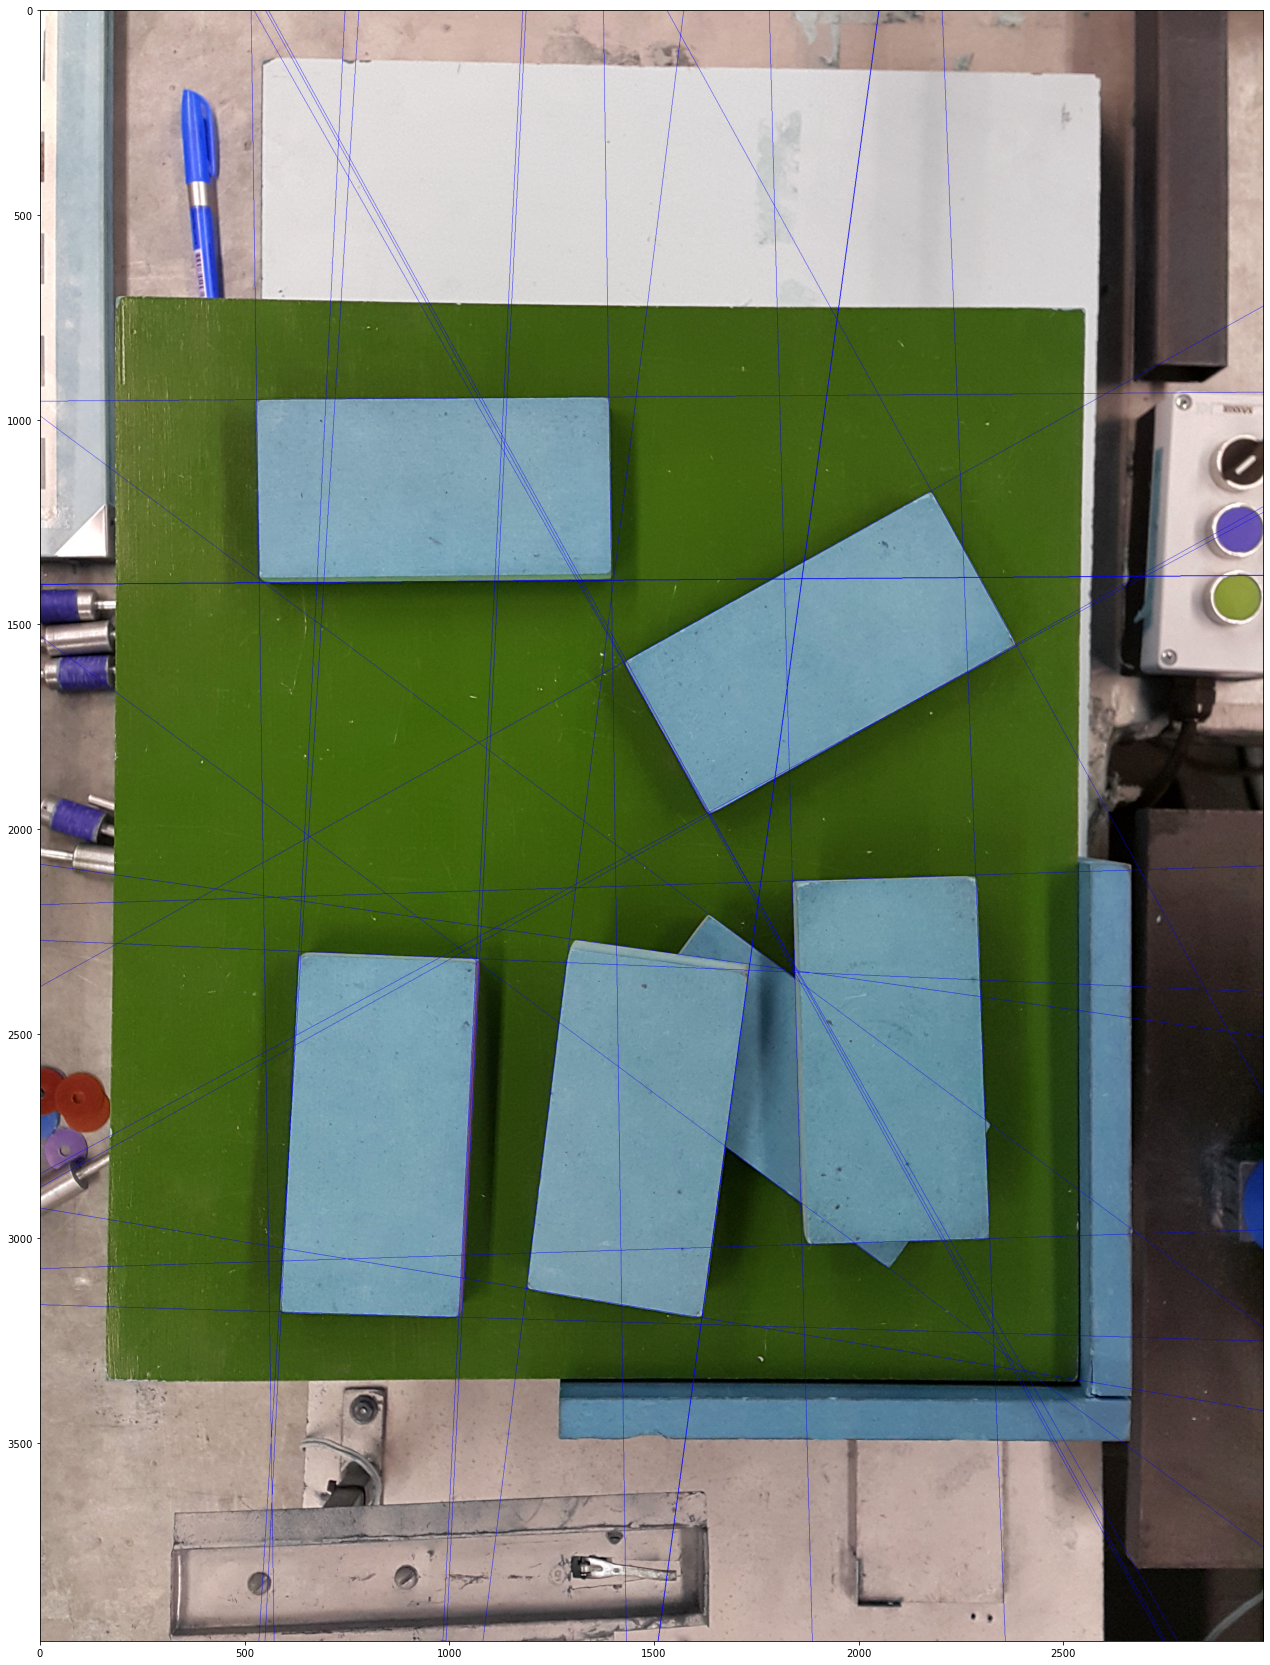

In [4]:
# Obtenemos las líneas por la transformada de Hough
#==================================================
rho_step = 0.7
theta_step = (np.pi/180)*0.7
thresh = 130
lines2 = cv.HoughLines(edges,rho_step,theta_step,thresh)

# Dibujamos lo resultados
#========================
for line in lines2:
    rho,theta = line[0]
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho
    x1 = int(x0 + 10000*(-b))
    y1 = int(y0 + 10000*(a))
    x2 = int(x0 - 10000*(-b))
    y2 = int(y0 - 10000*(a))
    cv.line(img2,(x1,y1),(x2,y2),(0,0,255),1)


plt.imshow(img2)
plt.show()

Vemos ahora que nos toma casi todas las lineas que buscamos, excepto por los lados mas cortos del bloque qué esta oculto. Que para que las reconozca teniamos que usar parametros que nos marcaban muchas mas líneas de lo desaeado. (incuso con los parámetros originales tampoco reconocia la linea inferior).

In [5]:
# Vamos a intentar implementar lo desarrollado en el paper: Rectangle Detection based on a Windowed Hough Transform.

# Lo primeor que hacemos es buscar en la lista de rectas cales de ellas tienen igual ángulo, asi encontramos pares de rectas paralelas:

rectas = []
candidatos = []

for line in lines2:
    rho,theta = line[0]
    rectas.append([rho,theta])

n = 1

for i in range(len(rectas)):
    for j in range(n, len(rectas)):
        if abs(rectas[j][1] - rectas[i][1]) < 0.03:
            candidatos.append([i,j])
    n += 1

    
# Ahora, sabiendo aproximadamente la medida de los rectangulos de antemano, podemos poner un máximo y un mínimo para la diferencia
# de los rho de estos pares de rectas, asi descartamos aquellos que esten muy cerca, o muy lejos.


candidatos2 = []

for candidato in candidatos:
    if 300 < (abs(rectas[candidato[0]][0] - rectas[candidato[1]][0])) < 900:
        candidatos2.append(candidato)
        
# Falta solucionar el problema de cuando hay 2 lineas parelelas muy cercanas, y su distancia a una tercera está dentro del rango
# Van a aparecer los dos pares, en vez de uno solo.


# Ahora vamos a buscar un valor de theta para cada uno de los pares calculados, como promedio de sus ángulos.

angulos = []

for candidato in candidatos2:
    angulos.append((rectas[candidato[0]][1] + rectas[candidato[1]][1])/2)


perpendiculares = []

n = 1

for i in range(len(angulos)):
    for j in range(n,len(angulos)):
        if abs(abs(angulos[j]-angulos[i])-(np.pi/2)) < 0.05:
            perpendiculares.append([i,j])

    n += 1

    

In [6]:
print(len(candidatos))
print(len(candidatos2))
print(len(perpendiculares))

37
23
33


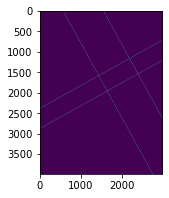

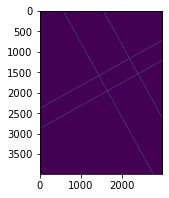

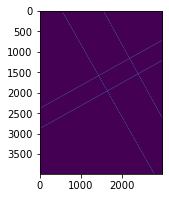

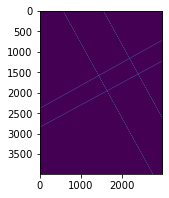

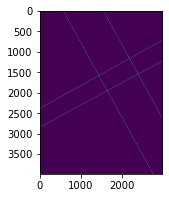

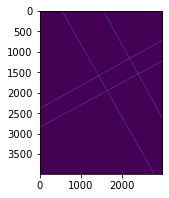

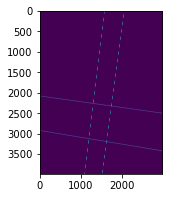

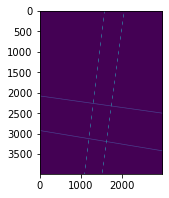

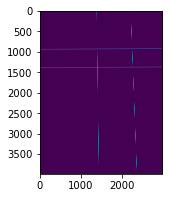

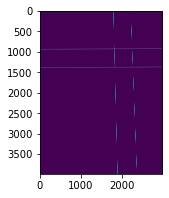

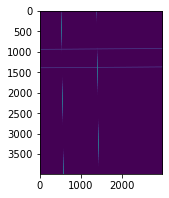

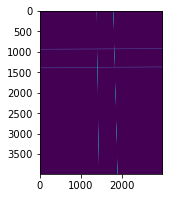

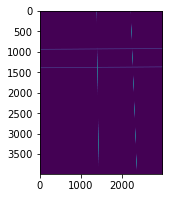

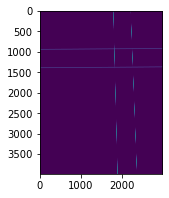

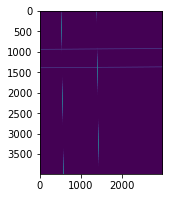

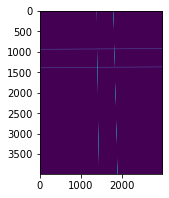

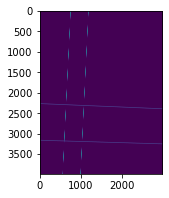

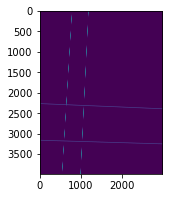

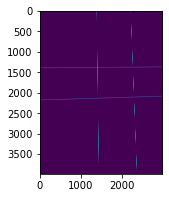

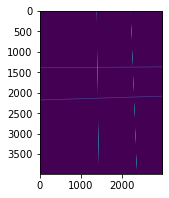

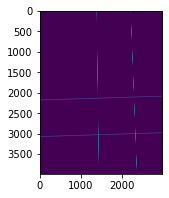

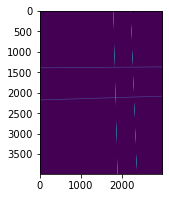

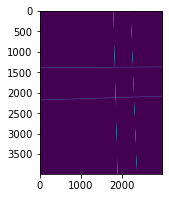

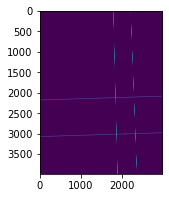

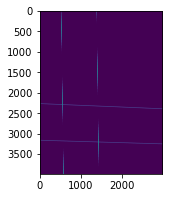

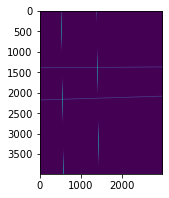

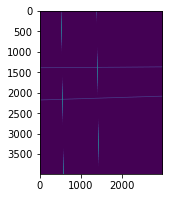

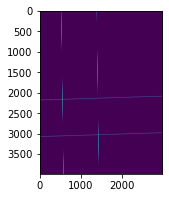

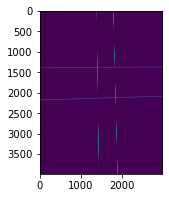

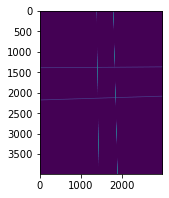

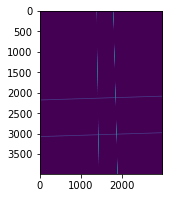

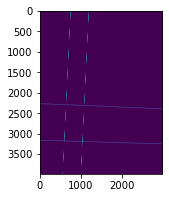

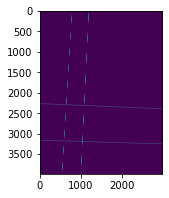

In [10]:
# Mostramos las lineas que tenemos como los lados de cada rectángulo en diferentes colores, para ver si se está logrando lo desado.
plt.rcParams["figure.figsize"] = (4,3)

for perpendicular in perpendiculares:
    
    mascara = np.zeros((img.shape[0], img.shape[1]))
    
    color1 = (list(np.random.choice(range(256), size=3)))  
    color =[int(color1[0]), int(color1[1]), int(color1[2])]  
    
    rho,theta = lines2[candidatos2[perpendicular[0]][0]][0]
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho
    x1 = int(x0 + 10000*(-b))
    y1 = int(y0 + 10000*(a))
    x2 = int(x0 - 10000*(-b))
    y2 = int(y0 - 10000*(a))
    cv.line(mascara,(x1,y1),(x2,y2),color,2)

    rho,theta = lines2[candidatos2[perpendicular[1]][0]][0]
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho
    x1 = int(x0 + 10000*(-b))
    y1 = int(y0 + 10000*(a))
    x2 = int(x0 - 10000*(-b))
    y2 = int(y0 - 10000*(a))
    cv.line(mascara,(x1,y1),(x2,y2),color,2)
    
    rho,theta = lines2[candidatos2[perpendicular[0]][1]][0]
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho
    x1 = int(x0 + 10000*(-b))
    y1 = int(y0 + 10000*(a))
    x2 = int(x0 - 10000*(-b))
    y2 = int(y0 - 10000*(a))
    cv.line(mascara,(x1,y1),(x2,y2),color,2)

    rho,theta = lines2[candidatos2[perpendicular[1]][1]][0]
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho
    x1 = int(x0 + 10000*(-b))
    y1 = int(y0 + 10000*(a))
    x2 = int(x0 - 10000*(-b))
    y2 = int(y0 - 10000*(a))
    cv.line(mascara,(x1,y1),(x2,y2),color,2)

    plt.imshow(mascara)
    plt.show()

Vemos que los 5 bloques del frente quedan bien definidos, el problema es que hay muchas lineas paralelas cercanas, dando varios rectangulos donde deberia marcar solo uno. Esto es dificil de corregir cambiando los limites que pusimos ya que la perspectiva hace que no todos los angulos de los rectangulos sean perfectamente rectos, y si se baja mucho la cota, quedan afuera lineas necesarias.

En el paper se propone una solucion a esto, teniendo en cuenta los errores.

Otro error que aparece son los falsos rectangulos, encontrados por "casualidad" de pares de rectas paralelas que no se corresponden con un bloque en particular.


Tenemos ahora los pares parpendiculares de pares paralelos, por lo tanto tengo las cuatro rectas que forman cada rectangulo.

Falta encontrar los vertices como las interseciones de estas rectas y asi poder dibujar los rectangulos.

Para esto, usamos la ecuacion parametrizada de la recta:

$\rho = x cos(\theta) = y sin(\theta)$


Si tenemos dos rectas que se intersectan:

$\rho_1 = x cos(\theta_1) = y sin(\theta_1)$
$\rho_2= x cos(\theta_2) = y sin(\theta_2)$

Despejando $y$:

$y = (\frac{\rho_1}{cos(\theta_1)} - \frac{\rho_2}{cos(\theta_2)})  /  (tg(\theta_1) - tg(\theta_2) $

$x = \frac{y sin(\theta_1) - \rho_1}{cos(\theta_1)}$

In [8]:
def interseccion(rho_1,theta_1,rho_2,theta_2):
    y = ((rho_1/np.cos(theta_1))-((rho_2/np.cos(theta_2)))/(np.tan(theta_1)-np.tan(theta_2)))
    x = (y*(np.sin(theta_1)-rho_1))/(np.cos(theta_1))
    return x,y

for perpendicular in perpendiculares:
    
    rho_1,theta_1 = lines2[candidatos2[perpendicular[0]][0]][0]
    rho_2,theta_2 = lines2[candidatos2[perpendicular[0]][1]][0]
    rho_3,theta_3 = lines2[candidatos2[perpendicular[1]][0]][0]
    rho_4,theta_4 = lines2[candidatos2[perpendicular[1]][1]][0]
    
    cv.circle(img, interseccion(rho_1,theta_1,rho_3,theta_3), 20, (0,0,255),1)
    cv.circle(img, interseccion(rho_2,theta_2,rho_3,theta_3), 20, (0,0,255),1)
    cv.circle(img, interseccion(rho_1,theta_1,rho_4,theta_4), 20, (0,0,255),1)
    cv.circle(img, interseccion(rho_2,theta_2,rho_4,theta_4), 20, (0,0,255),1)

<ipython-input-8-10aa381b8b5e>:13: DeprecationWarning: an integer is required (got type numpy.float32).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  cv.circle(img, interseccion(rho_1,theta_1,rho_3,theta_3), 20, (0,0,255),1)
<ipython-input-8-10aa381b8b5e>:14: DeprecationWarning: an integer is required (got type numpy.float32).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  cv.circle(img, interseccion(rho_2,theta_2,rho_3,theta_3), 20, (0,0,255),1)
<ipython-input-8-10aa381b8b5e>:15: DeprecationWarning: an integer is required (got type numpy.float32).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  cv.circle(img, interseccion(rho_1,theta_1,rho_4,theta_4), 20, (0,0,255),1)
<ipython-input-8-10aa381b8b5e>:16: DeprecationWarning: an integer is required (got type numpy.float32).  Implicit convers

OverflowError: signed integer is less than minimum

Todavia tenemos un error al calcular la posición de las intersecciones, que no nos permite terminar de graficar.